## Visualization scripts for single-player Type Through the Bible files

(Still very much a work in progress--many more analyses to come, including word-level ones and accuracy-focused graphs!)

By Ken Burchfiel

Released under the MIT License

In [1]:
import time
start_time = time.time()
import pandas as pd # Polars could also be used in place of Pandas to 
# speed up some import/analysis processes--but, if there ends up being
# a need for faster data transformation code, I would rather do it in 
# C++ (as a means of building up my practice with that language.)
pd.set_option('display.max_columns', 1000)
import plotly.express as px
import numpy as np
sp_visualizations_folder = '../Visualizations/Single_Player/'

## Analyzing test result file:

In [2]:
df_tr = pd.read_csv('../Files/test_results.csv') # tr = 'test results'

#Converting start/end timestamps to DateTime values:
for col in ['Local_Test_Start_Time', 'Local_Test_End_Time']:
    df_tr[col] = pd.to_datetime(df_tr[col])
# Ensuring the tests are being displayed in chronological order:
# (This may not always be the case, especially if the player imported
# multiplayer results into his/her single-player file.)
# (This will help ensure that the 'chronological test number' values 
# that we're about to create are accurate.)
df_tr = df_tr.sort_values(
    'Local_Test_Start_Time').reset_index(drop=True).copy()

df_tr['Chronological test number'] = df_tr.index+1

df_tr

,Test_Number,Within_Session_Test_Number,Unix_Test_Start_Time,Local_Test_Start_Time,Unix_Test_End_Time,Local_Test_End_Time,Verse_ID,Verse_Code,Verse,Characters,WPM,Test_Seconds,Error_Rate,Error_and_Backspace_Rate,Marathon_Mode,Player,Mode,Tag_1,Tag_2,Tag_3,Notes,Chronological test number
0,1,NaN,1750909743,2025-06-25 23:49:03-04:00,1750909747,2025-06-25 23:49:07-04:00,1,Genesis_1:1,"In the beginning, God created heaven and earth.",47,124.928204,4.514593,0.021277,0.042553,0,KJB3,SP,Cherry_Red,NaN,NaN,NaN,1
1,2,NaN,1750910427,2025-06-26 00:00:27-04:00,1750910430,2025-06-26 00:00:30-04:00,1,Genesis_1:1,"In the beginning, God created heaven and earth.",47,181.050428,3.115154,0.000000,0.000000,0,KJB3,SP,Cherry_Red,NaN,NaN,NaN,2
2,3,NaN,1750910839,2025-06-26 00:07:19-04:00,1750910854,2025-06-26 00:07:34-04:00,2,Genesis_1:2,"But the earth was empty and unoccupied, and da...",141,113.465015,14.912085,0.120567,0.205674,1,KJB3,SP,Cherry_Red,NaN,NaN,NaN,3
3,4,NaN,1750910854,2025-06-26 00:07:34-04:00,1750910860,2025-06-26 00:07:40-04:00,3,Genesis_1:3,"And God said, ""Let there be light."" And light ...",53,110.773001,5.741471,0.018868,0.037736,1,KJB3,SP,Cherry_Red,NaN,NaN,NaN,4
4,5,NaN,1750910860,2025-06-26 00:07:40-04:00,1750910869,2025-06-26 00:07:49-04:00,4,Genesis_1:4,"And God saw the light, that it was good; and s...",89,116.464066,9.170210,0.078652,0.157303,1,KJB3,SP,Cherry_Red,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,841,21.0,1753406370,2025-07-24 21:19:30-04:00,1753406384,2025-07-24 21:19:44-04:00,827,Genesis_29:32,"Having conceived, she gave birth to a son, and...",142,121.224545,14.056559,0.042254,0.084507,0,KJB3,SP,Ga15pyd_Laptop,Home,NaN,NaN,849
849,850,1.0,1753416367,2025-07-25 00:06:07-04:00,1753416381,2025-07-25 00:06:21-04:00,8000,1-Samuel_30:26,"Then David went to Ziklag, and he sent gifts f...",168,145.778876,13.829164,0.029762,0.059524,0,KJB3,MP,Cherry_Red,Home,NaN,NaN,850
850,851,2.0,1753416383,2025-07-25 00:06:23-04:00,1753416392,2025-07-25 00:06:32-04:00,8001,1-Samuel_30:27,"to those who were in Bethel, and who were in R...",93,127.585198,8.747096,0.139785,0.172043,0,KJB3,MP,Cherry_Red,Home,NaN,NaN,851
851,852,3.0,1753416394,2025-07-25 00:06:34-04:00,1753416402,2025-07-25 00:06:42-04:00,8002,1-Samuel_30:28,"and who were in Aroer, and who were in Siphmot...",74,112.662327,7.881960,0.013514,0.027027,0,KJB3,MP,Cherry_Red,Home,NaN,NaN,852


Calculating various timing statistics that will prove useful for endurance-related analyses:

In [3]:
for time_type in ['Start', 'End']:
    df_tr[f'{time_type} Date'] = df_tr[
        f'Local_Test_{time_type}_Time'].dt.date
    df_tr[f'{time_type} Hour'] = df_tr[
        f'Local_Test_{time_type}_Time'].dt.hour
    df_tr[f'{time_type} Minute'] = df_tr[
        f'Local_Test_{time_type}_Time'].dt.minute
    df_tr[f'{time_type} 30-Minute Block'] = np.where(
        df_tr[f'{time_type} Minute'] >= 30, 2, 1)
    # Using floor division to determine the 15- and 10-minute blocks
    # into which each test falls:
    df_tr[f'{time_type} 15-Minute Block'] = df_tr[
        f'{time_type} Minute'] // 15 + 1
    df_tr[f'{time_type} 10-Minute Block'] = df_tr[
        f'{time_type} Minute'] // 10 + 1

# Creating columns that will store unique starting hours and
# 30/15/10-minute blocks:
df_tr['Unique Hour'] = df_tr['Start Date'].astype(
    'str') + '_' + df_tr['Start Hour'].astype('str')
for block in ['30', '15', '10']:
    df_tr[f'Unique {block}-Minute Block'] = df_tr[
        'Unique Hour'] + '_' + df_tr[
        f'Start {block}-Minute Block'].astype('str')


df_tr.head(5)

,Test_Number,Within_Session_Test_Number,Unix_Test_Start_Time,Local_Test_Start_Time,Unix_Test_End_Time,Local_Test_End_Time,Verse_ID,Verse_Code,Verse,Characters,WPM,Test_Seconds,Error_Rate,Error_and_Backspace_Rate,Marathon_Mode,Player,Mode,Tag_1,Tag_2,Tag_3,Notes,Chronological test number,Start Date,Start Hour,Start Minute,Start 30-Minute Block,Start 15-Minute Block,Start 10-Minute Block,End Date,End Hour,End Minute,End 30-Minute Block,End 15-Minute Block,End 10-Minute Block,Unique Hour,Unique 30-Minute Block,Unique 15-Minute Block,Unique 10-Minute Block
0,1,NaN,1750909743,2025-06-25 23:49:03-04:00,1750909747,2025-06-25 23:49:07-04:00,1,Genesis_1:1,"In the beginning, God created heaven and earth.",47,124.928204,4.514593,0.021277,0.042553,0,KJB3,SP,Cherry_Red,NaN,NaN,NaN,1,2025-06-25,23,49,2,4,5,2025-06-25,23,49,2,4,5,2025-06-25_23,2025-06-25_23_2,2025-06-25_23_4,2025-06-25_23_5
1,2,NaN,1750910427,2025-06-26 00:00:27-04:00,1750910430,2025-06-26 00:00:30-04:00,1,Genesis_1:1,"In the beginning, God created heaven and earth.",47,181.050428,3.115154,0.000000,0.000000,0,KJB3,SP,Cherry_Red,NaN,NaN,NaN,2,2025-06-26,0,0,1,1,1,2025-06-26,0,0,1,1,1,2025-06-26_0,2025-06-26_0_1,2025-06-26_0_1,2025-06-26_0_1
2,3,NaN,1750910839,2025-06-26 00:07:19-04:00,1750910854,2025-06-26 00:07:34-04:00,2,Genesis_1:2,"But the earth was empty and unoccupied, and da...",141,113.465015,14.912085,0.120567,0.205674,1,KJB3,SP,Cherry_Red,NaN,NaN,NaN,3,2025-06-26,0,7,1,1,1,2025-06-26,0,7,1,1,1,2025-06-26_0,2025-06-26_0_1,2025-06-26_0_1,2025-06-26_0_1
3,4,NaN,1750910854,2025-06-26 00:07:34-04:00,1750910860,2025-06-26 00:07:40-04:00,3,Genesis_1:3,"And God said, ""Let there be light."" And light ...",53,110.773001,5.741471,0.018868,0.037736,1,KJB3,SP,Cherry_Red,NaN,NaN,NaN,4,2025-06-26,0,7,1,1,1,2025-06-26,0,7,1,1,1,2025-06-26_0,2025-06-26_0_1,2025-06-26_0_1,2025-06-26_0_1
4,5,NaN,1750910860,2025-06-26 00:07:40-04:00,1750910869,2025-06-26 00:07:49-04:00,4,Genesis_1:4,"And God saw the light, that it was good; and s...",89,116.464066,9.170210,0.078652,0.157303,1,KJB3,SP,Cherry_Red,NaN,NaN,NaN,5,2025-06-26,0,7,1,1,1,2025-06-26,0,7,1,1,1,2025-06-26_0,2025-06-26_0_1,2025-06-26_0_1,2025-06-26_0_1


## Determining how many characters the player typed after each *rolling* hour, 30-minute period, 15-minute period, and 10-minute period:

(This information will be helpful for calculating endurance-based statistics.)

In [4]:
col_seconds_pair_list = [['Characters Typed in Next Hour', 3600],
                         ['Characters Typed in Next 30 Minutes', 1800],
                         ['Characters Typed in Next 15 Minutes', 900],
                         ['Characters Typed in Next 10 Minutes', 600]]

Note: the following code will likely take a considerable amount of time to run once users have completed a significant number of tests (e.g. 1000+). Therefore, it would be ideal to eventually replace it with C++-based code *or* a more sophisticated Python-based approach. (I tried out the 'numba' engine setting within the df.apply() function, but it failed to work correctly.)

In the meantime, I've commented out this code so that it won't cause performance issues going forward.

In [5]:
# df_tr_condensed = df_tr[['Unix_Test_Start_Time', 
# 'Unix_Test_End_Time', 'Characters', 'Test number']].copy()
# I thought this DataFrame might be more compatible with certain
# alternative engine options, but unfortunately, that wasn't the case.

In [6]:
# for col_seconds_pair in col_seconds_pair_list:

#     df_tr[col_seconds_pair[0]] = df_tr.apply(
#         lambda x: df_tr[(df_tr[
#             'Unix_Test_Start_Time'] >= x['Unix_Test_Start_Time']) & (
#             df_tr['Unix_Test_End_Time'] 
#         < (x['Unix_Test_Start_Time'] + col_seconds_pair[1]))][
#             'Characters'].sum(), axis = 1)
# df_tr

Note: I thought the following approach might actually be faster than the above option, as it only requires a single loop through the whole DataFrame. However, I found it to take a bit longer than the previous method.

In [7]:
# for col in ['characters_typed_in_next_hour',
#             'characters_typed_in_next_30_minutes',
#             'characters_typed_in_next_15_minutes',
#             'characters_typed_in_next_10_minutes']:
#     df_tr[col] = 0
# for i in range(len(df_tr)):
#     start_time = df_tr.iloc[i]['Unix_Test_Start_Time'].astype(
#         'int64')
    
#     df_tr.iloc[i, df_tr.columns.get_loc(
#         'characters_typed_in_next_hour')] = df_tr[(
#         df_tr[
#         'Unix_Test_Start_Time'] >= start_time) & (df_tr[
#             'Unix_Test_End_Time'] 
#         < (start_time + 3600))]['Characters'].sum()
    
#     df_tr.iloc[i, df_tr.columns.get_loc(
#         'characters_typed_in_next_30_minutes')] = df_tr[(
#         df_tr[
#         'Unix_Test_Start_Time'] >= start_time) & (df_tr[
#             'Unix_Test_End_Time'] 
#         < (start_time + 1800))]['Characters'].sum()

#     df_tr.iloc[i, df_tr.columns.get_loc(
#             'characters_typed_in_next_15_minutes')] = df_tr[(
#             df_tr[
#             'Unix_Test_Start_Time'] >= start_time) & (df_tr[
#                 'Unix_Test_End_Time'] 
#             < (start_time + 900))]['Characters'].sum()
    
#     df_tr.iloc[i, df_tr.columns.get_loc(
#             'characters_typed_in_next_10_minutes')] = df_tr[(
#             df_tr[
#             'Unix_Test_Start_Time'] >= start_time) & (df_tr[
#                 'Unix_Test_End_Time'] 
#             < (start_time + 600))]['Characters'].sum()
            

In [8]:
# df_tr

### WPM results by test:

In [9]:
fig_wpm_by_test = px.line(
    df_tr, x = 'Chronological test number', y = 'WPM',
title = 'WPM by Chronological Test Number',)
fig_wpm_by_test.write_html(f'{sp_visualizations_folder}WPM_by_race.html',
                           include_plotlyjs = 'cdn')

### Average WPM by Tag 1 values:

In [10]:
df_wpm_by_tag_1 = df_tr.pivot_table(index = 'Tag_1', values = 'WPM',
                                 aggfunc = 'mean').reset_index()
df_wpm_by_tag_1

,Tag_1,WPM
0,Cherry_Black,129.164296
1,Cherry_Brown,130.184895
2,Cherry_Red,129.653151
3,Ga15pyd_Laptop,129.632090


In [11]:
fig_wpm_by_tag_1 = px.bar(df_wpm_by_tag_1, x = 'Tag_1', y = 'WPM',
                         title = 'Mean WPM by Tag_1 value')
fig_wpm_by_tag_1.write_html(f'{sp_visualizations_folder}/Mean_WPM_\
by_Tag_1.html',
                            include_plotlyjs = 'cdn')

## Creating endurance-related charts:

## Visualizing *rolling* endurance statistics:

(I commented out the following visualization code because it relies on a very inefficient set of code that I have also commented out.)

In [12]:
# for col in [pair[0] for pair in col_seconds_pair_list]:

#     df_endurance = df_tr.sort_values(col, ascending = False).copy(
#     ).reset_index(drop=True).head(50)
#     df_endurance['Rank'] = (df_endurance.index + 1)

#     fig_endurance = px.bar(
#     df_endurance, x = 'Rank', 
#     y = col,
#     title = 'Most ' + col,
#     hover_data = ['Chronological test number', 'Local_Test_Start_Time'])
    
#     fig_endurance.write_html('Single_Player/Endurance_Top_50_rolling_'+col.replace(
#         ' ', '_')+'.html', 
#     include_plotlyjs = 'cdn')

## Visualizing clock-based endurance statistics:

In [13]:
for time_category in ['Hour', '30-Minute Block', '15-Minute Block',
                      '10-Minute Block']:
    # The following code helps confirm that the following query() statement
    # is correctly filtering out tests whose starting and ending 
    # time categories don't match.
    # print(len(df_tr.query(f"`Start {time_category}` == `End {time_category}`")))
    df_endurance = df_tr.query(f"`Start {time_category}` == `End {time_category}`").pivot_table(
        index = f'Unique {time_category}', values = 'Characters', 
    aggfunc = 'sum').reset_index().sort_values(
    'Characters', ascending = False).reset_index(drop=True).head(50)
    df_endurance['Rank'] = (df_endurance.index + 1)
    
    fig_endurance = px.bar(
    df_endurance, x = f'Unique {time_category}', 
    y = 'Characters',
    title = 'Most Characters Typed By ' + time_category,
    hover_data = 'Rank')
    
    fig_endurance.write_html(
    f'{sp_visualizations_folder}Endurance_Top_50_\
Clock_'+time_category.replace(' ', '_')+'.html', 
    include_plotlyjs = 'cdn')

Graphing keypresses by date (in both chronological and ranked order):

In [14]:
df_top_dates_by_keypresses = df_tr.query(
    "`Start Date` == `End Date`").pivot_table(
    index = 'Start Date', values = 'Characters', 
    aggfunc = 'sum').reset_index().sort_values(
    'Characters', ascending = False).reset_index(drop=True)
df_top_dates_by_keypresses['Rank'] = df_top_dates_by_keypresses.index + 1
# Plotly will automatically arrange these dates in chronological order 
# despite our having sorted the source DataFrame by characters.
fig_keypresses_by_date = px.bar(df_top_dates_by_keypresses,
                                     x = 'Start Date', y = 'Characters',
                              title = 'Characters typed by date',
                               hover_data = ['Rank'])
fig_keypresses_by_date.write_html(f'{sp_visualizations_folder}Keypresses\
_Typed_by_Date.html', include_plotlyjs='cdn')

In [15]:
fig_top_dates_by_keypresses = px.bar(
    df_top_dates_by_keypresses.head(50),
       x = 'Start Date', y = 'Characters',
       title = 'Dates with the most characters typed', 
       hover_data = ['Rank']).update_layout(
    xaxis_type = 'category')
fig_top_dates_by_keypresses.write_html(
    f'{sp_visualizations_folder}/Top_Dates_by_Keypresses.html', 
    include_plotlyjs='cdn')

In [16]:
## Calculating mean WPMs by test number:

In [17]:
df_tr.head()

,Test_Number,Within_Session_Test_Number,Unix_Test_Start_Time,Local_Test_Start_Time,Unix_Test_End_Time,Local_Test_End_Time,Verse_ID,Verse_Code,Verse,Characters,WPM,Test_Seconds,Error_Rate,Error_and_Backspace_Rate,Marathon_Mode,Player,Mode,Tag_1,Tag_2,Tag_3,Notes,Chronological test number,Start Date,Start Hour,Start Minute,Start 30-Minute Block,Start 15-Minute Block,Start 10-Minute Block,End Date,End Hour,End Minute,End 30-Minute Block,End 15-Minute Block,End 10-Minute Block,Unique Hour,Unique 30-Minute Block,Unique 15-Minute Block,Unique 10-Minute Block
0,1,NaN,1750909743,2025-06-25 23:49:03-04:00,1750909747,2025-06-25 23:49:07-04:00,1,Genesis_1:1,"In the beginning, God created heaven and earth.",47,124.928204,4.514593,0.021277,0.042553,0,KJB3,SP,Cherry_Red,NaN,NaN,NaN,1,2025-06-25,23,49,2,4,5,2025-06-25,23,49,2,4,5,2025-06-25_23,2025-06-25_23_2,2025-06-25_23_4,2025-06-25_23_5
1,2,NaN,1750910427,2025-06-26 00:00:27-04:00,1750910430,2025-06-26 00:00:30-04:00,1,Genesis_1:1,"In the beginning, God created heaven and earth.",47,181.050428,3.115154,0.000000,0.000000,0,KJB3,SP,Cherry_Red,NaN,NaN,NaN,2,2025-06-26,0,0,1,1,1,2025-06-26,0,0,1,1,1,2025-06-26_0,2025-06-26_0_1,2025-06-26_0_1,2025-06-26_0_1
2,3,NaN,1750910839,2025-06-26 00:07:19-04:00,1750910854,2025-06-26 00:07:34-04:00,2,Genesis_1:2,"But the earth was empty and unoccupied, and da...",141,113.465015,14.912085,0.120567,0.205674,1,KJB3,SP,Cherry_Red,NaN,NaN,NaN,3,2025-06-26,0,7,1,1,1,2025-06-26,0,7,1,1,1,2025-06-26_0,2025-06-26_0_1,2025-06-26_0_1,2025-06-26_0_1
3,4,NaN,1750910854,2025-06-26 00:07:34-04:00,1750910860,2025-06-26 00:07:40-04:00,3,Genesis_1:3,"And God said, ""Let there be light."" And light ...",53,110.773001,5.741471,0.018868,0.037736,1,KJB3,SP,Cherry_Red,NaN,NaN,NaN,4,2025-06-26,0,7,1,1,1,2025-06-26,0,7,1,1,1,2025-06-26_0,2025-06-26_0_1,2025-06-26_0_1,2025-06-26_0_1
4,5,NaN,1750910860,2025-06-26 00:07:40-04:00,1750910869,2025-06-26 00:07:49-04:00,4,Genesis_1:4,"And God saw the light, that it was good; and s...",89,116.464066,9.170210,0.078652,0.157303,1,KJB3,SP,Cherry_Red,NaN,NaN,NaN,5,2025-06-26,0,7,1,1,1,2025-06-26,0,7,1,1,1,2025-06-26_0,2025-06-26_0_1,2025-06-26_0_1,2025-06-26_0_1


In [18]:
df_mean_wpm_by_within_session_test_number = df_tr.pivot_table(
    index = 'Within_Session_Test_Number',
                  values = ['WPM', 'Chronological test number'], 
                  aggfunc = {'WPM':'mean', 
                             'Chronological test number':'count'}).reset_index().rename(
    columns = {'Chronological test number':'Number of tests'})
df_mean_wpm_by_within_session_test_number

,Within_Session_Test_Number,Number of tests,WPM
0,1.0,12,144.868785
1,2.0,11,145.219891
2,3.0,7,130.157185
3,4.0,5,146.145317
4,5.0,2,136.140902
5,6.0,2,111.223752
6,7.0,2,132.753462
7,8.0,2,105.138556
8,9.0,2,117.602968
9,10.0,2,125.582223


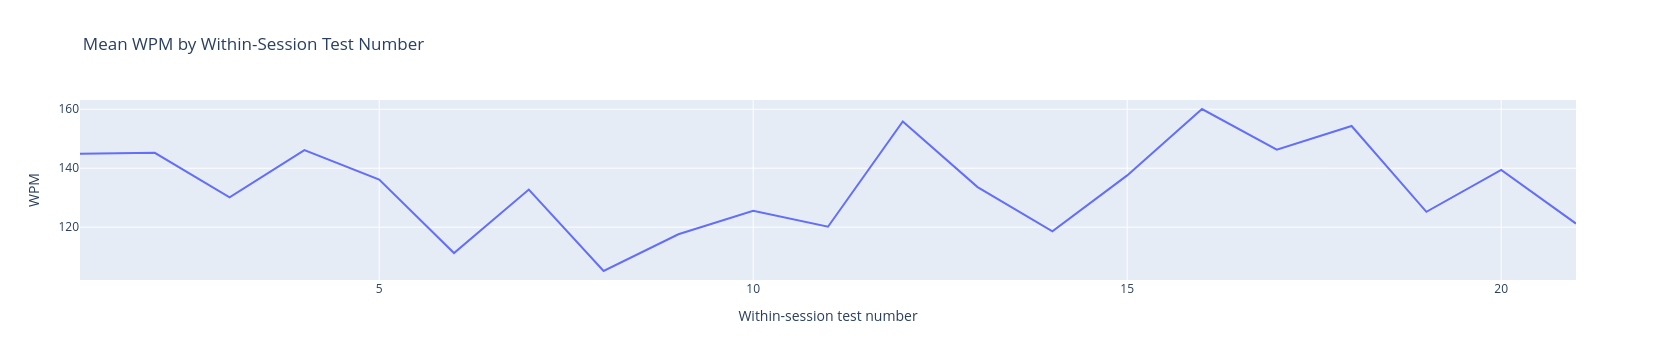

In [19]:
fig_mean_wpm_by_within_session_test_number = px.line(
    df_mean_wpm_by_within_session_test_number,
    x = 'Within_Session_Test_Number', y = 'WPM',
    title = 'Mean WPM by Within-Session Test Number',
    hover_data = 'Number of tests').update_layout(
    xaxis_title = 'Within-session test number')
fig_mean_wpm_by_within_session_test_number.write_html(
    f'{sp_visualizations_folder}/Mean_WPM_by_Within_Session_Test_Number.html', 
    include_plotlyjs='cdn')
fig_mean_wpm_by_within_session_test_number

In [20]:
# Creating a string version of the test number field that will allow it
# to get used as a color value for the following chart:
# (I found that, when this value was passed as an integer, no lines
# appeared within the chart.)
df_tr['Chronological test number as string'] = df_tr[
'Chronological test number'].astype('str')

In [21]:
df_tr.query(
    "Within_Session_Test_Number.notna()").sort_values(
'Chronological test number').copy()

,Test_Number,Within_Session_Test_Number,Unix_Test_Start_Time,Local_Test_Start_Time,Unix_Test_End_Time,Local_Test_End_Time,Verse_ID,Verse_Code,Verse,Characters,WPM,Test_Seconds,Error_Rate,Error_and_Backspace_Rate,Marathon_Mode,Player,Mode,Tag_1,Tag_2,Tag_3,Notes,Chronological test number,Start Date,Start Hour,Start Minute,Start 30-Minute Block,Start 15-Minute Block,Start 10-Minute Block,End Date,End Hour,End Minute,End 30-Minute Block,End 15-Minute Block,End 10-Minute Block,Unique Hour,Unique 30-Minute Block,Unique 15-Minute Block,Unique 10-Minute Block,Chronological test number as string
794,795,1.0,1753156345,2025-07-21 23:52:25-04:00,1753156352,2025-07-21 23:52:32-04:00,781,Genesis_28:8,having evidence also that his father did not l...,90,168.992686,6.390809,0.000000,0.000000,0,KJB3,SP,Cherry_Red,NaN,NaN,NaN,795,2025-07-21,23,52,2,4,6,2025-07-21,23,52,2,4,6,2025-07-21_23,2025-07-21_23_2,2025-07-21_23_4,2025-07-21_23_6,795
795,796,2.0,1753156360,2025-07-21 23:52:40-04:00,1753156373,2025-07-21 23:52:53-04:00,782,Genesis_28:9,"he went to Ishmael, and he took as a wife, bes...",144,132.035605,13.087379,0.027778,0.055556,0,KJB3,SP,Cherry_Red,NaN,NaN,NaN,796,2025-07-21,23,52,2,4,6,2025-07-21,23,52,2,4,6,2025-07-21_23,2025-07-21_23_2,2025-07-21_23_4,2025-07-21_23_6,796
796,797,1.0,1753157077,2025-07-22 00:04:37-04:00,1753157083,2025-07-22 00:04:43-04:00,783,Genesis_28:10,"Meanwhile Jacob, having departed from Beersheb...",71,158.429362,5.377791,0.000000,0.000000,0,KJB3,SP,Cherry_Red,NaN,NaN,NaN,797,2025-07-22,0,4,1,1,1,2025-07-22,0,4,1,1,1,2025-07-22_0,2025-07-22_0_1,2025-07-22_0_1,2025-07-22_0_1,797
797,798,2.0,1753157084,2025-07-22 00:04:44-04:00,1753157097,2025-07-22 00:04:57-04:00,784,Genesis_28:11,"And when he had arrived at a certain place, wh...",197,172.344262,13.716732,0.000000,0.000000,0,KJB3,SP,Cherry_Red,NaN,NaN,NaN,798,2025-07-22,0,4,1,1,1,2025-07-22,0,4,1,1,1,2025-07-22_0,2025-07-22_0_1,2025-07-22_0_1,2025-07-22_0_1,798
798,799,1.0,1753157504,2025-07-22 00:11:44-04:00,1753157519,2025-07-22 00:11:59-04:00,785,Genesis_28:12,And he saw in his sleep: a ladder standing upo...,144,121.825972,14.184168,0.055556,0.069444,0,KJB3,SP,Cherry_Red,NaN,NaN,NaN,799,2025-07-22,0,11,1,1,2,2025-07-22,0,11,1,1,2,2025-07-22_0,2025-07-22_0_1,2025-07-22_0_1,2025-07-22_0_2,799
799,800,2.0,1753157521,2025-07-22 00:12:01-04:00,1753157537,2025-07-22 00:12:17-04:00,786,Genesis_28:13,"and the Lord, leaning upon the ladder, saying ...",195,145.659219,16.064895,0.015385,0.030769,0,KJB3,SP,Cherry_Red,NaN,NaN,NaN,800,2025-07-22,0,12,1,1,2,2025-07-22,0,12,1,1,2,2025-07-22_0,2025-07-22_0_1,2025-07-22_0_1,2025-07-22_0_2,800
800,801,3.0,1753157540,2025-07-22 00:12:20-04:00,1753157561,2025-07-22 00:12:41-04:00,787,Genesis_28:14,And your offspring will be like the dust of th...,226,124.501498,21.782870,0.079646,0.132743,0,KJB3,SP,Cherry_Red,NaN,NaN,NaN,801,2025-07-22,0,12,1,1,2,2025-07-22,0,12,1,1,2,2025-07-22_0,2025-07-22_0_1,2025-07-22_0_1,2025-07-22_0_2,801
801,802,1.0,1753159004,2025-07-22 00:36:44-04:00,1753159018,2025-07-22 00:36:58-04:00,788,Genesis_28:15,And I will be your guardian wherever you will ...,173,148.405079,13.988740,0.005780,0.011561,0,KJB3,SP,Cherry_Red,NaN,NaN,NaN,802,2025-07-22,0,36,2,3,4,2025-07-22,0,36,2,3,4,2025-07-22_0,2025-07-22_0_2,2025-07-22_0_3,2025-07-22_0_4,802
802,803,2.0,1753159022,2025-07-22 00:37:02-04:00,1753159030,2025-07-22 00:37:10-04:00,789,Genesis_28:16,"And when Jacob had awakened from sleep, he sai...",107,148.629494,8.638931,0.000000,0.000000,0,KJB3,SP,Cherry_Red,NaN,NaN,NaN,803,2025-07-22,0,37,2,3,4,2025-07-22,0,37,2,3,4,2025-07-22_0,2025-07-22_0_2,2025-07-22_0_3,2025-07-22_0_4,803
803,804,1.0,1753159814,2025-07-22 00:50:14-04:00,1753159826,2025-07-22 00:50:26-04:00,790,Genesis_28:17,"And being terrified, he said: ""How terrible th...",130,134.531302,11.595814,0.030769,0.061538,0,KJB3,SP,Cherry_Red,NaN,NaN,Testing_Notes_Function,804,2025-07-22,0,50,2,4,6,2025-07-22,0,50,2,4,6,2025-07-22_0,2025-07-22_0_2,2025-0

In [23]:
df_tr_for_wpm_by_session = df_tr.query(
"Within_Session_Test_Number.notna()").copy()
df_tr_for_wpm_by_session[
'Within_Session_Test_Number'] = df_tr_for_wpm_by_session[
'Within_Session_Test_Number'].astype('int')
df_tr_for_wpm_by_session

,Test_Number,Within_Session_Test_Number,Unix_Test_Start_Time,Local_Test_Start_Time,Unix_Test_End_Time,Local_Test_End_Time,Verse_ID,Verse_Code,Verse,Characters,WPM,Test_Seconds,Error_Rate,Error_and_Backspace_Rate,Marathon_Mode,Player,Mode,Tag_1,Tag_2,Tag_3,Notes,Chronological test number,Start Date,Start Hour,Start Minute,Start 30-Minute Block,Start 15-Minute Block,Start 10-Minute Block,End Date,End Hour,End Minute,End 30-Minute Block,End 15-Minute Block,End 10-Minute Block,Unique Hour,Unique 30-Minute Block,Unique 15-Minute Block,Unique 10-Minute Block,Chronological test number as string
794,795,1,1753156345,2025-07-21 23:52:25-04:00,1753156352,2025-07-21 23:52:32-04:00,781,Genesis_28:8,having evidence also that his father did not l...,90,168.992686,6.390809,0.000000,0.000000,0,KJB3,SP,Cherry_Red,NaN,NaN,NaN,795,2025-07-21,23,52,2,4,6,2025-07-21,23,52,2,4,6,2025-07-21_23,2025-07-21_23_2,2025-07-21_23_4,2025-07-21_23_6,795
795,796,2,1753156360,2025-07-21 23:52:40-04:00,1753156373,2025-07-21 23:52:53-04:00,782,Genesis_28:9,"he went to Ishmael, and he took as a wife, bes...",144,132.035605,13.087379,0.027778,0.055556,0,KJB3,SP,Cherry_Red,NaN,NaN,NaN,796,2025-07-21,23,52,2,4,6,2025-07-21,23,52,2,4,6,2025-07-21_23,2025-07-21_23_2,2025-07-21_23_4,2025-07-21_23_6,796
796,797,1,1753157077,2025-07-22 00:04:37-04:00,1753157083,2025-07-22 00:04:43-04:00,783,Genesis_28:10,"Meanwhile Jacob, having departed from Beersheb...",71,158.429362,5.377791,0.000000,0.000000,0,KJB3,SP,Cherry_Red,NaN,NaN,NaN,797,2025-07-22,0,4,1,1,1,2025-07-22,0,4,1,1,1,2025-07-22_0,2025-07-22_0_1,2025-07-22_0_1,2025-07-22_0_1,797
797,798,2,1753157084,2025-07-22 00:04:44-04:00,1753157097,2025-07-22 00:04:57-04:00,784,Genesis_28:11,"And when he had arrived at a certain place, wh...",197,172.344262,13.716732,0.000000,0.000000,0,KJB3,SP,Cherry_Red,NaN,NaN,NaN,798,2025-07-22,0,4,1,1,1,2025-07-22,0,4,1,1,1,2025-07-22_0,2025-07-22_0_1,2025-07-22_0_1,2025-07-22_0_1,798
798,799,1,1753157504,2025-07-22 00:11:44-04:00,1753157519,2025-07-22 00:11:59-04:00,785,Genesis_28:12,And he saw in his sleep: a ladder standing upo...,144,121.825972,14.184168,0.055556,0.069444,0,KJB3,SP,Cherry_Red,NaN,NaN,NaN,799,2025-07-22,0,11,1,1,2,2025-07-22,0,11,1,1,2,2025-07-22_0,2025-07-22_0_1,2025-07-22_0_1,2025-07-22_0_2,799
799,800,2,1753157521,2025-07-22 00:12:01-04:00,1753157537,2025-07-22 00:12:17-04:00,786,Genesis_28:13,"and the Lord, leaning upon the ladder, saying ...",195,145.659219,16.064895,0.015385,0.030769,0,KJB3,SP,Cherry_Red,NaN,NaN,NaN,800,2025-07-22,0,12,1,1,2,2025-07-22,0,12,1,1,2,2025-07-22_0,2025-07-22_0_1,2025-07-22_0_1,2025-07-22_0_2,800
800,801,3,1753157540,2025-07-22 00:12:20-04:00,1753157561,2025-07-22 00:12:41-04:00,787,Genesis_28:14,And your offspring will be like the dust of th...,226,124.501498,21.782870,0.079646,0.132743,0,KJB3,SP,Cherry_Red,NaN,NaN,NaN,801,2025-07-22,0,12,1,1,2,2025-07-22,0,12,1,1,2,2025-07-22_0,2025-07-22_0_1,2025-07-22_0_1,2025-07-22_0_2,801
801,802,1,1753159004,2025-07-22 00:36:44-04:00,1753159018,2025-07-22 00:36:58-04:00,788,Genesis_28:15,And I will be your guardian wherever you will ...,173,148.405079,13.988740,0.005780,0.011561,0,KJB3,SP,Cherry_Red,NaN,NaN,NaN,802,2025-07-22,0,36,2,3,4,2025-07-22,0,36,2,3,4,2025-07-22_0,2025-07-22_0_2,2025-07-22_0_3,2025-07-22_0_4,802
802,803,2,1753159022,2025-07-22 00:37:02-04:00,1753159030,2025-07-22 00:37:10-04:00,789,Genesis_28:16,"And when Jacob had awakened from sleep, he sai...",107,148.629494,8.638931,0.000000,0.000000,0,KJB3,SP,Cherry_Red,NaN,NaN,NaN,803,2025-07-22,0,37,2,3,4,2025-07-22,0,37,2,3,4,2025-07-22_0,2025-07-22_0_2,2025-07-22_0_3,2025-07-22_0_4,803
803,804,1,1753159814,2025-07-22 00:50:14-04:00,1753159826,2025-07-22 00:50:26-04:00,790,Genesis_28:17,"And being terrified, he said: ""How terrible th...",130,134.531302,11.595814,0.030769,0.061538,0,KJB3,SP,Cherry_Red,NaN,NaN,Testing_Notes_Function,804,2025-07-22,0,50,2,4,6,2025-07-22,0,50,2,4,6,2025-07-22_0,2025-07-22_0_2,2025-07-22_0_4,2025-07-22_

Not sure why lines aren't appearing within the following chart; I'll need to debug this further.

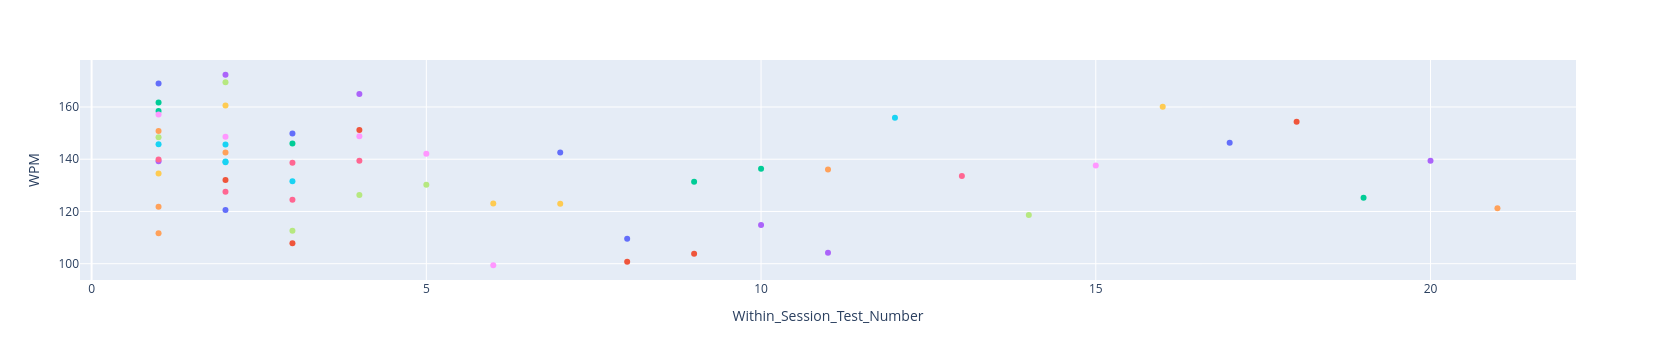

In [24]:
fig_wpm_by_session_num_comparison = px.line(df_tr_for_wpm_by_session,
        x = 'Within_Session_Test_Number', y = 'WPM',
       color = 'Chronological test number as string').update_traces(
    mode = 'markers+lines').update_layout(showlegend = False)
fig_wpm_by_session_num_comparison.write_html(
    f'{sp_visualizations_folder}/WPM_by_Within_Session_Test_Number.html', 
    include_plotlyjs='cdn')
fig_wpm_by_session_num_comparison

In [25]:
end_time = time.time()
run_time = end_time - start_time
print(f"Finished calculating and visualizing single-player stats in \
{round(run_time, 3)} seconds.")

Finished calculating and visualizing single-player stats in 38.394 seconds.
